In [1]:
import re
import os
import csv
import numpy as np
import pandas as pd
from itertools import chain
from scipy.stats import linregress

import thesis_tools
from thesis_tools.utilities import get_f_star

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import Normalize
from seaborn import xkcd_palette

plt.style.use('sm')

% matplotlib inline

In [2]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()

sl_data=thesis_tools.load_data(primary_sightlines)
all_data=thesis_tools.load_results(sl_data)

/Users/codydirks/python/thesis_tools/loaders.py:107: RuntimeWarning: divide by zero encountered in log10
  n_dict[ion+'_err']=round(np.log10(n_err),3)
/Users/codydirks/python/thesis_tools/utilities.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))


In [5]:
# Gets sightline data listed in Jenkins Table 2
sdcols=['logNHI','logNH2']
sightline_data=pd.read_csv('jenkins_table2.csv').drop('n_logNHI',1)
for col in sdcols:
    sightline_data=sightline_data[[len(x.strip())>0 for x in sightline_data[col]]].reset_index(drop=True)
sightline_data['Name']=pd.Series([x.strip() for x in sightline_data['Name']])
sightline_data['HD']=pd.Series(['HD'+x.strip() for x in sightline_data['HD']])
sightline_data[['logNHI','logNH2']]=sightline_data[['logNHI','logNH2']].apply(pd.to_numeric)
sightline_data['N(H)']=np.log10(10**(sightline_data['logNHI'])+2*10**(sightline_data['logNH2']))

# Adds CO column densities from Sheffer to sightline data if it exists
#sightline_data['CO']=pd.Series(np.zeros(len(sightline_data)))
#sheffer_co_h2=pd.read_csv('sheffer_co_h2.csv')
#with open('sheffer_co_h2.csv','r') as myfile:
#    for line in myfile:
#        hd=line.split(',')[0]
#        if hd in sightline_data['HD'].unique():
#            idx=sightline_data.loc[sightline_data['HD']==hd].index.values[0]
#            sightline_data.set_value(idx,'CO',float(line.split(',')[2]))
            
            
sightline_data['E(B-V)']=pd.Series(np.array([-9.99]*len(sightline_data)))
sightline_data['E(15-33)']=pd.Series(np.array([-9.99]*len(sightline_data)))
sightline_data['E(33-V)']=pd.Series(np.array([-9.99]*len(sightline_data)))
with open('jenkins_fuv_data.csv','r') as myfile:
    next(myfile) # Skips header line in file
    for line in myfile:
        hd,ebv,e15,e33=line.split(',')
        if hd in sightline_data['HD'].unique():
            idxs=sightline_data.loc[sightline_data['HD']==hd].index.values
            for idx in idxs:
                sightline_data.set_value(idx,'E(B-V)',float(ebv))
                sightline_data.set_value(idx,'E(15-33)',float(e15))
                sightline_data.set_value(idx,'E(33-V)',float(e33))

            

epcols=['Ax','Bx','zx']
element_params=pd.read_csv('jenkins_table4.csv')
element_params[epcols]=element_params[epcols].apply(pd.to_numeric)
element_params['El']=pd.Series([x.strip() for x in element_params['El']])

fcols=['F*o','e_F*o']
f_results=pd.read_csv('jenkins_table5.csv')
f_results['HD']=pd.Series(['HD'+x.strip() for x in f_results['HD']])
for col in fcols:
    f_results[col]=pd.Series([x.strip() for x in f_results[col]])
f_results[fcols]=f_results[fcols].apply(pd.to_numeric)

edcols=['logNx','b_logNx','B_logNx','F*','[X/H]']
element_data=pd.read_csv('jenkins_table7.csv')
for col in edcols:
    element_data=element_data[[len(x.strip())>0 for x in element_data[col]]].reset_index(drop=True)
element_data['Name']=pd.Series([x.strip() for x in element_data['Name']])
element_data['El']=pd.Series([x.strip() for x in element_data['El']])
element_data['HD']=pd.Series(['HD'+x.strip() for x in element_data['HD']])
element_data=element_data[[(x in sightline_data['Name'].values) for x in element_data['Name'].values]]
element_data[edcols]=element_data[edcols].apply(pd.to_numeric)

with open('sheffer_co_h2.csv','r') as myfile:
    next(myfile) # Skips first header line
    for line in myfile:
        hd=line.split(',')[0]
        empty=pd.Series({col:0 for col in element_data.columns})
        empty['El']='CO'
        empty['HD']=hd
        empty['logNx']=float(line.split(',')[2])
        element_data=element_data.append(empty,ignore_index=True)
        #if hd in element['HD'].unique():
        #    idx=sightline_data.loc[sightline_data['HD']==hd].index.values[0]
        #    sightline_data.set_value(idx,'CO',float(line.split(',')[2]))

#element_data=pd.pivot_table(element_data,index=['HD','El']).unstack()

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Text(0.5,0,u'Log N($^{12}$CO)')

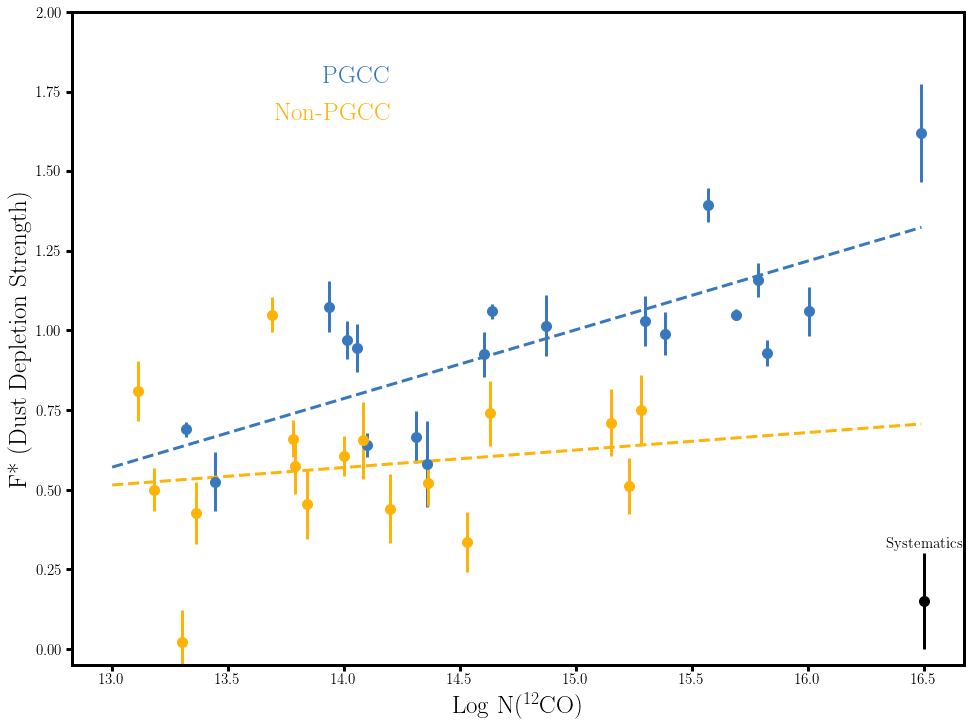

In [16]:
# Plots all calculated F* values against a given x parameter

els=['Ge','Kr','O','Ni','Mg']
els=['Ni','O','Ge']
cols=['r','g','b','k','y']
el1='Ni'

cut_data=all_data[(all_data['CO']>13)&(all_data['CO']<18)&(all_data['R_dist']<20)]

blue=xkcd_palette(['windows blue'])[0]
amber=xkcd_palette(['amber'])[0]

fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
subplt.set_ylim(-0.2,2)
#subplt.set_xlim(0,0.0001)

# Plots F* vs. CO in blue for strongest CO component in each of my sightlines
fit1x=np.empty(0)
fit1y=np.empty(0)
for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    x=row['CO']
    #x=np.log10(np.sum([10**row[c] for c in ('C','C*','C**')]))
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=get_f_star(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
            #subplt.plot(row[x],f,marker='o',color=cols[els.index(el2)])
    f_err=np.sqrt(np.sum(f_errs**2))
    subplt.errorbar(x,np.mean(f_vals),yerr=f_err,marker='o',color=blue,markersize=10)
    #subplt.text(x,np.mean(f_vals),row['Sightline'])
    fit1x=np.concatenate([fit1x,[x]])
    fit1y=np.concatenate([fit1y,[np.mean(f_vals)]])
    #subplt.text(x,1.95,row['Sightline'],rotation=90,horizontalalignment='center',verticalalignment='top')
    
    
# Plots F* vs. CO in red for other sightlines (i.e. those not in my sample) from Jenkins x Sheffer sample
fit2x=np.empty(0)
fit2y=np.empty(0)
for idx,row in element_data[(element_data['El']=='CO') & (element_data['logNx']>0)].iterrows():
    x=row['logNx']
    el1row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el1)]
    el1param=element_params[element_params['El']==el1].iloc[0]
    if len(el1row)>0:
        el1row=el1row.iloc[0]
        el1n=el1row['logNx']
        el1_frac_err=(el1row['B_logNx']-el1row['b_logNx'])/2.
        el1err=np.log10(el1_frac_err/0.434)+el1n
        f_vals=np.empty(0)
        f_errs=np.empty(0)
        for el2 in [y for y in els if y != el1]:
            el2row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el2)]
            el2param=element_params[element_params['El']==el2].iloc[0]
            if len(el2row)>0:
                el2row=el2row.iloc[0]
                el2n=el2row['logNx']
                el2_frac_err=(el2row['B_logNx']-el2row['b_logNx'])/2.
                el2err=np.log10(el2_frac_err/0.434)+el2n
                f,f_err=get_f_star(el1param,el2param,el1n,el2n,el1err,el2err)
                f_vals=np.concatenate([f_vals,[f]])
                f_errs=np.concatenate([f_errs,[f_err]])
                #subplt.plot(co,f,marker='x',color=cols[els.index(el2)])
        f_err=np.sqrt(np.sum(f_errs**2))
        subplt.errorbar(x,np.mean(f_vals),yerr=f_err,marker='o',color=amber,markersize=10)
        #subplt.text(x,np.mean(f_vals),row['Sightline'])
        fit2x=np.concatenate([fit2x,[x]])
        fit2y=np.concatenate([fit2y,[np.mean(f_vals)]])
        
fit1=linregress(x=fit1x,y=fit1y)
fit2=linregress(x=fit2x,y=fit2y) 

trendx=np.arange(13,16.5,0.01)
y1=fit1.slope*trendx+fit1.intercept
y2=fit2.slope*trendx+fit2.intercept
subplt.plot(trendx,y1,color=blue,linestyle='--',lw=3)
subplt.plot(trendx,y2,color=amber,linestyle='--',lw=3)

# Systematics Legend
subplt.errorbar(16.5,0.15,yerr=0.15,marker='o',color='k',markersize=10)
subplt.text(16.5,0.32,'Systematics',horizontalalignment='center',fontsize=15)

#subplt.plot(13,1.8,marker='o',color=blue,markersize=20)
subplt.text(14.2,1.8,'PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=blue)
#subplt.plot(13,1.7,marker='o',color=amber,markersize=20)
subplt.text(14.2,1.68,'Non-PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=amber)

#subplt.set_xlim(12.9,16.8)
subplt.set_ylim(-0.05)
subplt.tick_params(axis='both', which='major', labelsize=15)
subplt.set_ylabel('F* (Dust Depletion Strength)',fontsize=25)
subplt.set_xlabel('Log N($^{12}$CO)',fontsize=25)
#plt.savefig('/Users/codydirks/Desktop/dustco.pdf')

In [ ]:
# Plots all calculated F* values against a given x parameter
x='CO'

els=['Ge','Kr','O','Ni','Mg']
els=['Ni','O','Ge']
el1='Ni'

cut_data=all_data[(all_data['CO']>13)&(all_data['CO']<18)&(all_data['R_dist']<20)]

fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)

# Plots F* vs. CO in blue for strongest CO component in each of my sightlines
fit1x=np.empty(0)
fit1y=np.empty(0)
for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=get_f_star(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f_err=np.sqrt(np.sum(f_errs**2))
    subplt.errorbar(row[x],np.mean(f_vals),yerr=f_err,marker='o',color=blue,markersize=10)
    fit1x=np.concatenate([fit1x,[row[x]]])
    fit1y=np.concatenate([fit1y,[np.mean(f_vals)]])
    
# Plots F* vs. CO in black for integrated column densities along each of my sightlines

fit3x=np.empty(0)
fit3y=np.empty(0)
for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    rows=all_data[all_data['Sightline']==sl[0]]
    co_sum=np.log10(np.sum(np.array(10**rows['CO'].values)))
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    el1_sum=np.log10(np.sum(np.array(10**rows[el1].values)))
    el1_err=np.log10(np.sum(np.array(10**rows[el1+'_err'].values)))
    for el2 in [y for y in els if y != el1]:
        if np.sum(rows[el2].values)>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            el2_sum=np.log10(np.sum(np.array(10**rows[el2].values)))
            el2_err=np.log10(np.sum(np.array(10**rows[el2+'_err'].values)))
            f,f_err=get_f_star(el1param,el2param,el1_sum,el2_sum,el1_err,el2_err)
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f_err=np.sqrt(np.sum(f_errs**2))
    subplt.errorbar(co_sum,np.mean(f_vals),yerr=0.05,marker='o',color='k',markersize=10)
    fit3x=np.concatenate([fit3x,[co_sum]])
    fit3y=np.concatenate([fit3y,[np.mean(f_vals)]])
    
# Plots F* vs. CO in yellow for other sightlines (i.e. those not in my sample) from Jenkins x Sheffer sample
fit2x=np.empty(0)
fit2y=np.empty(0)
for idx,row in sightline_data[sightline_data['CO']>0].iterrows():
    co=row['CO']
    el1row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el1)]
    el1param=element_params[element_params['El']==el1].iloc[0]
    if len(el1row)>0:
        el1row=el1row.iloc[0]
        el1n=el1row['logNx']
        el1err=(el1row['B_logNx']-el1row['b_logNx'])/2.
        f_vals=np.empty(0)
        f_errs=np.empty(0)
        for el2 in [y for y in els if y != el1]:
            el2row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el2)]
            el2param=element_params[element_params['El']==el2].iloc[0]
            if len(el2row)>0:
                el2row=el2row.iloc[0]
                el2n=el2row['logNx']
                el2err=(el2row['B_logNx']-el2row['b_logNx'])/2.
                f,f_err=get_f_star(el1param,el2param,el1n,el2n,el1err,el2err)
                f_vals=np.concatenate([f_vals,[f]])
                f_errs=np.concatenate([f_errs,[f_err]])
                #subplt.plot(co,f,marker='x',color=cols[els.index(el2)])
        f_err=np.sqrt(np.sum(f_errs**2))
        subplt.errorbar(co,np.mean(f_vals),yerr=f_err,marker='o',color=amber,markersize=10)
        #subplt.text(co,np.mean(f_vals),row['Sightline'])
        fit2x=np.concatenate([fit2x,[co]])
        fit2y=np.concatenate([fit2y,[np.mean(f_vals)]])
        
fit1=linregress(x=fit1x,y=fit1y)
fit2=linregress(x=fit2x,y=fit2y) 
fit3=linregress(x=fit3x,y=fit3y) 

x=np.arange(13,16.5,0.01)
y1=fit1.slope*x+fit1.intercept
y2=fit2.slope*x+fit2.intercept
y3=fit3.slope*x+fit3.intercept
subplt.plot(x,y1,color=blue,linestyle='--',lw=3)
subplt.plot(x,y2,color=amber,linestyle='--',lw=3)
subplt.plot(x,y3,color='k',linestyle='--',lw=3)

In [ ]:
# Recreates Jenkins plots for given elements
els=['Nickel','Germanium','Krypton']
cols=[blue,amber,'k']
fig=plt.figure(1,figsize=(16,16))
subplt=plt.subplot(111)
subplt.axvline(0,0,0.98,color='k',linestyle='-')
subplt.axhline(0,0.05,1,color='k',linestyle='-')
tx=np.arange(-0.1,1.5,0.1)

for element in els:
    el=element[0:2]
    eldata=element_params.loc[element_params['El']==el].iloc[0]
    ty=eldata['Bx']+eldata['Ax']*(tx-eldata['zx'])
    subplt.plot(tx,ty,'k--')
    for idx,row in element_data.loc[(element_data['El']==el)].iterrows():
        sldata=sightline_data.loc[sightline_data['Name']==row['Name']].iloc[0]
        depl=row['logNx']-sldata['N(H)']-(eldata['[X/H]']-12)
        subplt.plot(row['F*'],depl,marker='o',color=cols[els.index(element)],ms=9)
    subplt.text(tx[-1],ty[-1]+0.03,element,horizontalalignment='right',verticalalignment='bottom',
                fontsize=20,rotation=0.58*(180./np.pi)*np.arctan(eldata['Ax']))
    
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)
subplt.set_xlabel('F* (Dust Depletion Strength)',fontsize=25,labelpad=20)
subplt.set_ylabel('Observed Depletion (dex)',fontsize=25,labelpad=20)
plt.savefig('/Users/codydirks/Desktop/jenkins_examples.pdf')

In [ ]:
els=['Ni','O']
el1='Ni'

fig=plt.figure(1,figsize=(16,8))
subplt=plt.subplot(111)
#subplt.set_xlim(13,16)

cut_data=all_data[(all_data['E(B-V)']>-9.99) & (all_data['CO']>13)]

for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]            
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=get_f_star(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f_err=np.sqrt(np.sum(f_errs**2))
    fuv_ext=(row['E(15-33)'])/row['E(B-V)']
    subplt.plot(np.mean(f_vals),fuv_ext,marker='o',color=blue,markersize=25)
    #subplt.text(np.mean(f_vals),fuv_ext,row['Sightline'])
    
for idx,row in sightline_data[(sightline_data['E(15-33)']>-9.99)&(sightline_data['CO']>13)].iterrows():
    el1row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el1)]
    el1param=element_params[element_params['El']==el1].iloc[0]
    o_row=element_data[(element_data['HD']==row['HD']) & (element_data['El']=='O')]
    if len(el1row)>0 and len(o_row)>0:
        el1row=el1row.iloc[0]
        el1n=el1row['logNx']
        el1err=(el1row['B_logNx']-el1row['b_logNx'])/2.
        f_vals=np.empty(0)
        f_errs=np.empty(0)
        for el2 in [y for y in els if y != el1]:
            el2row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el2)]
            el2param=element_params[element_params['El']==el2].iloc[0]
            if len(el2row)>0:
                el2row=el2row.iloc[0]
                el2n=el2row['logNx']
                el2err=(el2row['B_logNx']-el2row['b_logNx'])/2.
                f,f_err=get_f_star(el1param,el2param,el1n,el2n,el1err,el2err)
                f_vals=np.concatenate([f_vals,[f]])
                f_errs=np.concatenate([f_errs,[f_err]])
                #subplt.plot(co,f,marker='x',color=cols[els.index(el2)])
        f_err=np.sqrt(np.sum(f_errs**2))
        fuv_ext=(row['E(15-33)'])/row['E(B-V)']
        subplt.plot(np.mean(f_vals),fuv_ext,marker='o',color=amber,markersize=25)
        #subplt.text(np.mean(f_vals),fuv_ext,row['HD'])
        
        
        
subplt.text(1.3,4.7,'PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=blue)
subplt.text(1.3,4.47,'Non-PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=amber)
subplt.tick_params(axis='both', which='major', labelsize=15)
subplt.set_xlabel('F* (Dust Depletion Strength)',fontsize=25,labelpad=15)
subplt.set_ylabel('E(1500A-3300A)/E(B-V) (FUV Extinction)',fontsize=25,labelpad=15)
        
#plt.savefig('/Users/codydirks/Desktop/fuvext_vs_f.pdf')

In [ ]:
els=['O','Ni','Mg','Ge','Kr']
els=['O','Ni','Ge']#,'Mg','Ge','Kr']
el1='Ni'

fig,(subplt1,subplt2,subplt3,subplt4) = plt.subplots(4, sharex=True,figsize=(16,20))
fig.subplots_adjust(hspace=0.1)

cut_data=all_data[(all_data['CO']>0)&(all_data['C']>0)&(all_data['Cl']>0)&(all_data['R_dist']<20)]

fit1x=np.empty(0)
fit1y=np.empty(0)
for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=get_f_star(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
            #subplt.plot(row[x],f,marker='o',color=cols[els.index(el2)])
    f_err=np.sqrt(np.sum(f_errs**2))
    
    subplt1.errorbar(row['R_dist'],np.mean(f_vals),yerr=f_err,marker='o',color='k',markersize=12)
    
    subplt2.errorbar(row['R_dist'],row['CO'],yerr=0.434*(10**(row['CO_err']-row['CO'])),color='k',marker='o',markersize=12)

    subplt3.errorbar(row['R_dist'],row['Cl'],yerr=0.434*(10**(row['Cl_err']-row['Cl'])),color='k',marker='o',markersize=12)
    
    subplt4.errorbar(row['R_dist'],np.log10(row['f_H2']),yerr=0,color='k',marker='o',markersize=12)
    
subplt1.set_ylim(-0.1,2.1)
subplt1.set_ylabel('F* (Dust Depletion)',fontsize=25,labelpad=15)
majorLocator = MultipleLocator(0.5)
subplt1.yaxis.set_major_locator(majorLocator)
subplt1.tick_params(axis='y', which='major', labelsize=20)

subplt2.set_ylim(12.8,17.2)
subplt2.set_ylabel('Log N($^{12}$CO)',fontsize=25,labelpad=15)
majorLocator = MultipleLocator(1.0)
subplt2.yaxis.set_major_locator(majorLocator)
subplt2.tick_params(axis='y', which='major', labelsize=20)

subplt3.set_ylim(12,16)
subplt3.set_ylabel('Log N(Cl \\textsc{i})',fontsize=25,labelpad=15)
majorLocator = MultipleLocator(1.0)
subplt3.yaxis.set_major_locator(majorLocator)
subplt3.tick_params(axis='y', which='major', labelsize=20)

subplt4.set_ylim(-1.4,0.4)
subplt4.set_ylabel('Log f$_{H_{2}}$',fontsize=25,labelpad=15)
subplt4.tick_params(axis='y', which='major', labelsize=20)

majorLocator = MultipleLocator(1.0)
subplt4.xaxis.set_major_locator(majorLocator)
subplt4.tick_params(axis='x',which='major',labelsize=20)
subplt4.set_xlabel('R (Distance from center)',fontsize=25,labelpad=15)
subplt4.set_xlim(-0.1,10.2)

plt.savefig('/Users/codydirks/Dropbox/Thesis/Thesis/figures/rdist_plots.png')

In [12]:
element_data[element_data['El']=='C']

,El,HD,Vcomp,Name,b_logNx,logNx,f_logNx,B_logNx,n_logNx,r_logNx,F*,e_F*,[X/H],e_[X/H],Res,sigma
0,C,HD24398,,{zeta} Per,17.26,17.34,,17.41,,CMJS96,0.88,0.05,-0.201,0.049,-0.111,-0.79
1,C,HD24534,,X Per,17.35,17.51,,17.62,,SFM98,0.90,0.06,-0.203,0.050,-0.085,-0.58
2,C,HD24912,,{xi} Per,17.64,17.78,,17.89,,C++91,0.83,0.02,-0.196,0.046,0.225,1.47
3,C,HD36861,,{lambda} Ori A,16.79,17.00,,17.14,,CMJS96,0.57,0.04,-0.169,0.071,-0.085,-0.39
4,C,HD57061,,{tau} CMa,16.78,16.96,,17.08,,SCGM97,0.39,0.04,-0.151,0.106,-0.045,-0.24
5,C,HD143275,,{delta} Sco,17.14,17.42,,17.62,,HYO82,0.90,0.03,-0.203,0.050,-0.006,-0.02
6,C,HD144217,,{beta}^1^ Sco,17.27,17.37,,17.45,,CMJS96,0.81,0.02,-0.194,0.045,-0.027,-0.25
7,C,HD147888,,{rho} Oph D,17.91,18.00,,18.07,,SLMC04,0.88,0.06,-0.201,0.049,0.003,0.02
8,C,HD149757,-15,{zeta} Oph,17.24,17.36,,17.45,,CMES93,1.05,0.02,-0.218,0.071,-0.033,-0.24
9,C,HD152590,,HD 152590,18.11,18.21,,18.29,,SLMC04,0.69,0.03,-0.182,0.052,0.464,4.03
